In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML
from regression import PCovR, KPCovR, SparseKPCovR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from kernels import center_kernel, center_kernel_fast
from kernels import center_kernel_oos, center_kernel_oos_fast
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5
from selection import FPS

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

In [3]:
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/kernel-tutorials')
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/analysis/scripts')
from utilities.classes import KPCovR as KPCovR2
from utilities.classes import PCovR as PCovR2
from helpers import l_regr, l_kpcovr

NOTE: there is variable name re-use between the different notebook "chapters". Each chapter should run independently, so it's probably a good idea to restart the kernel when moving between chapters

NOTE: all of the KPCovR fits will output a message saying no input data was provided -- this is b/c I haven't provided X data, but have provided a kernel, so it should still work as expected with the provided KPCovR utility. I have commented out the pieces in that utility that need X, since it's unnecessary here and doesn't play nicely with my keeping of structure-separated SOAP vectors as a list of arrays

NOTE: we throw out RWY since the KPCovR fitting will fail if RWY does not get assigned to the train set (ARPACK won't converge).

NOTE: per-component scaling of Y will give NaN if a property is all zero (which could be the case with one-hot encodings in this case, e.g., training on all IZA and testing on DEEM)

In [4]:
# TODO regress molar volume (KPCovR)

# Linear IZA+DEEM

## SVM

In [5]:
# Load train and test set indices
train_idxs = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_structures = train_idxs.size + test_idxs.size

In [6]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [7]:
# Load IZA cantons
cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons == 4)
cantons = np.delete(cantons, RWY)
n_iza = len(cantons)

In [8]:
cutoff = 6.0

# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)
deem_soaps_average = np.array([np.mean(soap, axis=0) for soap in deem_soaps])

iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)
iza_soaps.pop(RWY[0][0])
iza_soaps_average = np.array([np.mean(soap, axis=0) for soap in iza_soaps])

In [9]:
# Subselections of train set and test set for Deem
# For IZA, just split structures 50/50
n_deem_train = 100 #2250
n_deem_test = 100 #None

deem_idxs = np.arange(0, train_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs_train = train_idxs[deem_idxs[0:n_deem_train]]

deem_idxs = np.arange(0, test_idxs.size)
np.random.shuffle(deem_idxs)
deem_idxs_test = test_idxs[deem_idxs[0:n_deem_test]]

In [10]:
n_iza_train = int(n_iza / 2)
n_iza_test = n_iza - n_iza_train
iza_idxs = np.arange(0, n_iza)
np.random.shuffle(iza_idxs)
iza_idxs_train = iza_idxs[0:n_iza_train]
iza_idxs_test = iza_idxs[n_iza_train:]

In [11]:
deem_train_svm = deem_soaps_average[deem_idxs_train, :]
deem_test_svm = deem_soaps_average[deem_idxs_test, :]

iza_train_svm = iza_soaps_average[iza_idxs_train, :]
iza_test_svm = iza_soaps_average[iza_idxs_test, :]

train_svm = np.vstack((iza_train_svm, deem_train_svm))
test_svm = np.vstack((iza_test_svm, deem_test_svm))

In [12]:
# Build the collection of soap vectors
# as a list of numpy arrays, where each list element
# corresponds do a structure
deem_train = [deem_soaps[i] for i in deem_idxs_train]
deem_test = [deem_soaps[i] for i in deem_idxs_test]

iza_train = [iza_soaps[i] for i in iza_idxs_train]
iza_test = [iza_soaps[i] for i in iza_idxs_test]

train = iza_train + deem_train
test = iza_test + deem_test

In [13]:
# Centering
train_svm_center = np.mean(train_svm, axis=0)
train_svm_centered = train_svm - train_svm_center
test_svm_centered = test_svm - train_svm_center

# Scaling
train_svm_scale = np.linalg.norm(train_svm_centered) / np.sqrt(train_svm_centered.shape[0])
train_svm_centered = train_svm_centered / train_svm_scale
test_svm_centered = test_svm_centered / train_svm_scale

In [14]:
print(np.trace(train_svm_centered @ train_svm_centered.T))

211.99999999999997


In [15]:
print(deem_idxs_train)
print(deem_idxs_test)

[6541 5067 8545 2142 3052 7735 9666 4418 7563 9762 1253  839 6819 8884
 4836 7677 6639 3426 3031 8385 1306 4218 2533 3356 4983 2119 9158 8169
 2556    0 6324  385 6533 3619 7613 6576 4677  538  362 6979 1127 7020
 1312 2748 7006 4802 4699 1829 3654 2491 2595  914 9378 2227 4010 8464
 1680 9601 3460 3355 5586 4988  576 8115 2371 3397 2088 8987 2046 9583
 1426 6485 8600 1453 9534 8306 5378 3054 1458 9250 6204 7699  911  565
 1957 7392 5167 6092 4938 9955 1649 9521 9441 7441 5348 6050 6601 1693
  100 9485]
[6040 4504 1483 3694 6031 9063 6418 7046 9862  954 7997 5048 2257 1468
 4852 3359 1360 3050 4437 6143 9629 2966  460 4769 6142 4482 9442 8195
 6573 7847 5807 4517 2573  990 6798 2384 7416 3088 9525 8912 6846 7413
 9858  401 6514 2246 2483 8033 8322 3366 3256 6438 5846 7089 6943 8512
 7865  726 6436 3065  159 9366 2312 5886 2620 7585 1547 2583 1855 8714
 9450 8188 2674 9407 2877 8452 3647  740 2306 1517 4089 3824 3197 7145
 2687 7291  522 8791  233 7142 3741 5946 8144 2950 8523  694 9494

In [16]:
print(iza_idxs_train)
print(iza_idxs_test)

[161  44 222 126 179   6 200 202  21 204 157  19  41 184  99 112  94  80
 122  47 134  49 185 151  68  85 137 220   5  31 152  92  35  88 173 155
 108 198  48   3 144 191  45  73  20 121 115 195 201  58 218 141 124  84
  61  40 107 194 154 187  37  62  89 223  78 167 103 208 219 139 150 132
  10 105  18   4 164  59 189 213  13 111 120  76 203 188  81 190 148 163
 114 193  57 197 140 171  69 175 135 206 133 169  46  93   9 110  65  53
 128 159 180 166]
[ 23 138  14   2  74 130  32 129  55 217 102  24  91 216 160  51  11 199
 145 207 212  67  75  12 177  22 119 224  17 131   1  56  66 147  70 116
 165  54  39 178 210  95 174  33  96 176  30  25 142 170 158 118 123 101
 146  77  86  29  43 196 143  52 125  83  38   8  98 127  90 149 221   0
 106  71 192  72 104 186  15  16 211 205  97  82 100 183  26  28  63 117
 215  79 181 182   7 109 156  50 136  42 162  34  87 209  64 113 168 153
  36  60 214 172  27]


In [17]:
# Make classification labels for SVM
Y_svm_train = np.array(['IZA']*n_iza_train + ['DEEM']*n_deem_train)
Y_svm_test = np.array(['IZA']*n_iza_test + ['DEEM']*n_deem_test)

In [18]:
# SVM
lsvc = LinearSVC()
lsvc.fit(train_svm, Y_svm_train)

df_train = lsvc.decision_function(train_svm_centered)
df_test = lsvc.decision_function(test_svm_centered)

class_train = lsvc.predict(train_svm_centered)
class_test = lsvc.predict(test_svm_centered)

In [19]:
# Concatenate the "properties"
Y_train = np.reshape(df_train, (-1, 1))
Y_test = np.reshape(df_test, (-1, 1))

Y_mean = np.mean(df_train, axis=0)
Y_scale = np.linalg.norm(Y_train - Y_mean) / np.sqrt(Y_train.shape[0] / Y_train.shape[1])

Y_train = (Y_train - Y_mean) / Y_scale
Y_test = (Y_test - Y_mean) / Y_scale

## PCovR

In [20]:
pcovr = PCovR2(alpha=0.01, n_PC=2, regularization=1.0E-12, rcond=None, center=True, scale=True)
pcovr.fit(train_svm, Y_train)
T_train, Yp_train, _ = pcovr.transform(train_svm)
T_test, Yp_test, _ = pcovr.transform(test_svm)

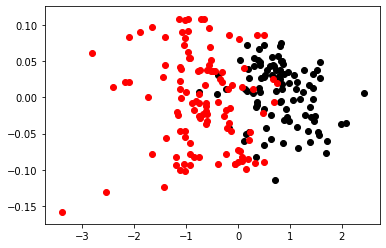

In [21]:
plt.scatter(T_train[n_iza_train:, 0], T_train[n_iza_train:, 1], c='k')
plt.scatter(T_train[0:n_iza_train, 0], T_train[0:n_iza_train, 1], c='r')
plt.show()

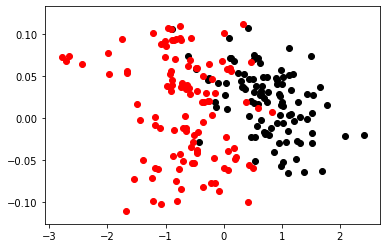

In [22]:
plt.scatter(T_test[n_iza_test:, 0], T_test[n_iza_test:, 1], c='k')
plt.scatter(T_test[0:n_iza_test, 0], T_test[0:n_iza_test, 1], c='r')
plt.show()

# Kernel IZA+DEEM

## Kernel SVM

In [23]:
# Load train and test set indices
train_idxs = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_structures = train_idxs.size + test_idxs.size

In [24]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [25]:
# Load IZA cantons
cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons == 4)
cantons = np.delete(cantons, RWY)
n_iza = len(cantons)

In [26]:
cutoff = 6.0

# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)

iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)
iza_soaps.pop(RWY[0][0])

array([[-0.00281038,  0.44229261,  0.12361648, ...,  0.00437123,
         0.00551277,  0.00056893],
       [-0.0028103 ,  0.44229261,  0.12361755, ...,  0.00437131,
         0.00551285,  0.00056887],
       [-0.00281031,  0.44229275,  0.1236168 , ...,  0.00437134,
         0.00551286,  0.0005689 ],
       ...,
       [-0.00281031,  0.44229311,  0.12361719, ...,  0.00437128,
         0.00551252,  0.00056898],
       [-0.00281059,  0.44229367,  0.12361391, ...,  0.00437097,
         0.00551275,  0.00056901],
       [-0.00281032,  0.44229303,  0.12361627, ...,  0.00437117,
         0.00551277,  0.00056894]])

In [27]:
# Subselections of train set and test set for Deem
# For IZA, just split structures 50/50
#n_deem_train = 1000 #2250
#n_deem_test = 1000 #None
#
#deem_idxs = np.arange(0, train_idxs.size)
#np.random.shuffle(deem_idxs)
#deem_idxs_train = train_idxs[deem_idxs[0:n_deem_train]]
#
#deem_idxs = np.arange(0, test_idxs.size)
#np.random.shuffle(deem_idxs)
#deem_idxs_test = test_idxs[deem_idxs[0:n_deem_test]]

deem_idxs_train = train_idxs
deem_idxs_test = test_idxs

n_deem_train = len(train_idxs)
n_deem_test = len(test_idxs)

In [28]:
n_iza_train = int(0.7750 * n_iza) #int(n_iza / 2)
n_iza_test = n_iza - n_iza_train
iza_idxs = np.arange(0, n_iza)
np.random.shuffle(iza_idxs)
iza_idxs_train = iza_idxs[0:n_iza_train]
iza_idxs_test = iza_idxs[n_iza_train:]

In [29]:
print(deem_idxs_train)
print(deem_idxs_test)

[2589 3514 8779 ... 2084 4756 6682]
[8895 4999 6163 ...  781 7771 6609]


In [30]:
print(iza_idxs_train)
print(iza_idxs_test)

[  6  19 108 124  25 101  60  57  42 176  34 216  80 120 118  14  95  69
  70 143  24 166  33  56  26 136 215  18 134  79  17 171 196 121 208 161
  36 173  30  27  71  11 206 153 205  38  86 182  16  58 157 198  91 109
  46   0 151 172 119 140 131  35 211 218 160  41  50 222 191  52 170 175
 181 202   5 137  93 123 213 162 210  81 212  23  40 122  15  37 217 142
  65 209 177  31 192   1 141  48 169 135  20 106 197 201 167  97  66 111
  90 114  94  49 187 112 183 220 127  44 107 100 159  89  98 145   9  32
 203  75  74  82  78 180  72  99 178 132 104  96 110  61 204  85 146 174
 158   3  92  47   4 156 163 223  51  29 129  88 103  63  13  67 117 155
  83  55 125  68  53   7 148 186   8 221 219 214]
[152 185  73 184 179 189 130 116 147  76 128  21 200  62 164 102  28 195
 224 188  45 194 165 207 168  43 139  59 193 105 113  54 144  10  77 115
 154 150   2  12 149 199  22 190  64  84 133 126  39 138  87]


In [33]:
# Build the collection of soap vectors
# as a list of numpy arrays, where each list element
# corresponds do a structure
deem_train = [deem_soaps[i] for i in deem_idxs_train]
deem_test = [deem_soaps[i] for i in deem_idxs_test]

iza_train = [iza_soaps[i] for i in iza_idxs_train]
iza_test = [iza_soaps[i] for i in iza_idxs_test]

train = iza_train + deem_train
test = iza_test + deem_test

In [44]:
# Make classification labels for SVM
#Y_svm_train = np.array(['IZA']*n_iza_train + ['DEEM']*n_deem_train)
#Y_svm_test = np.array(['IZA']*n_iza_test + ['DEEM']*n_deem_test)

Y_svm_train = np.zeros(len(train), dtype=int)
Y_svm_train[0:n_iza_train] = cantons[iza_idxs_train]
Y_svm_train[n_iza_train:] = 4

Y_svm_test = np.zeros(len(test), dtype=int)
Y_svm_test[0:n_iza_test] = cantons[iza_idxs_test]
Y_svm_test[n_iza_test:] = 4

In [45]:
for i in np.arange(1, 5):
    print(np.count_nonzero(Y_svm_train == i))
    print(np.count_nonzero(Y_svm_test == i))

22
13
98
24
54
14
7750
2250


In [ ]:
K_train = build_kernel(train, train, kernel='gaussian', gamma=10.0)
K_test = build_kernel(test, train, kernel='gaussian', gamma=10.0)
K_test_test = build_kernel(test, test, kernel='gaussian', gamma=10.0)

 14%|█▍        | 1147/7924 [33:02<2:53:39,  1.54s/it]

In [42]:
# Centering
K_test_test_centered = center_kernel_oos(K_test_test, K_test, K_train)
K_test_centered = center_kernel(K_test, K_ref=K_train)
K_train_centered = center_kernel(K_train)

# Scaling
K_scale = np.trace(K_train_centered) / np.shape(K_train_centered)[0]
K_test_test_centered /= K_scale
K_test_centered /= K_scale
K_train_centered /= K_scale

In [18]:
# SVM
# With 'balanced' class weights the predictions are a bit poorer, but the KPCovR projection
# looks largely the same
df_type = 'ovo'
svc = SVC(kernel='precomputed', decision_function_shape=df_type, class_weight='balanced')
svc.fit(K_train_centered, Y_svm_train)

df_train = svc.decision_function(K_train_centered)
df_test = svc.decision_function(K_test_centered)

class_train = svc.predict(K_train_centered)
class_test = svc.predict(K_test_centered)

In [19]:
print(svc.score(K_train_centered, Y_svm_train))
print(svc.score(K_test_centered, Y_svm_test))

0.9832155477031802
0.9691438504997827


In [20]:
# Concatenate the "properties"
#Y_train = np.reshape(df_train, (-1, 1))
#Y_test = np.reshape(df_test, (-1, 1))
Y_train = df_train
Y_test = df_test

Y_mean = np.mean(df_train, axis=0)
Y_scale = np.linalg.norm(Y_train - Y_mean) / np.sqrt(Y_train.shape[0] / Y_train.shape[1])

Y_train = (Y_train - Y_mean) / Y_scale
Y_test = (Y_test - Y_mean) / Y_scale

In [21]:
n_cols = Y_train.shape[1]

## KPCovR

In [50]:
# KPCovR parameters
alphas = np.linspace(0.0, 1.0, 11)
regs = np.logspace(-12, -1, 12)
n_kpcovr = 2

# Initialize matrices of losses
lrs_train = np.zeros((alphas.size, regs.size, n_cols))
lks_train = np.zeros((alphas.size, regs.size, n_cols))
lrs_test = np.zeros((alphas.size, regs.size, n_cols))
lks_test = np.zeros((alphas.size, regs.size, n_cols))
ltrs_train = np.zeros((alphas.size, regs.size))
ltks_train = np.zeros((alphas.size, regs.size))
ltrs_test = np.zeros((alphas.size, regs.size))
ltks_test = np.zeros((alphas.size, regs.size))

# Initialize matrices of classification accuracy
#class_train = np.zeros((alphas.size, regs.size))
#class_test = np.zeros((alphas.size, regs.size))

# CV indices
k_folds = 5
#k_idxs = np.arange(0, Y_train[0:112].shape[0]) # Only select IZA
k_idxs = np.arange(0, Y_train.shape[0])
np.random.shuffle(k_idxs)
k_idxs = np.array_split(k_idxs, k_folds) # Use array_split since train set size not divisible by k_folds
print([k.size for k in k_idxs])
print(k_idxs)

[1585, 1585, 1585, 1585, 1584]
[array([4773,  468, 1519, ..., 1602, 2002, 3685]), array([5457, 6892, 1192, ..., 3035, 1709, 6797]), array([ 309,  194, 6044, ..., 6136, 6051, 7099]), array([2489, 7146, 1890, ..., 1438, 2616, 5304]), array([6330, 3730, 7804, ..., 5182, 5191,  955])]


In [ ]:
# Determine optimal alpha and regularization via cross validation
for adx, alpha in enumerate(tqdm(alphas)):
    for rdx, r in enumerate(tqdm(regs, leave=False)):
        for k in tqdm(range(0, k_folds), leave=False):
            k_idxs_train = k_idxs.copy()
            k_idxs_validate = k_idxs_train.pop(k)
            k_idxs_train = np.concatenate(k_idxs_train)
            
            # Set kernels and properties for the fold
            k_train = K_train[k_idxs_train, :][:, k_idxs_train]
            k_test = K_train[k_idxs_validate, :][:, k_idxs_train]
            k_test_test = K_train[k_idxs_validate, :][:, k_idxs_validate]
            y_train = Y_train[k_idxs_train, :]
            y_test = Y_train[k_idxs_validate, :]
            
            # Center and scale for the fold
            y_center = np.mean(y_train, axis=0)
            y_train_centered = y_train - y_center
            y_test_centered = y_test - y_center
            y_scale = np.linalg.norm(y_train_centered, axis=0) \
                / np.sqrt(y_train_centered.shape[0] / y_train_centered.shape[1])
            y_train_centered = y_train_centered / y_scale
            y_test_centered = y_test_centered / y_scale
            
            # Even though we have auto-centering and auto-scaling,
            # center and scale here for the loss functions
            k_test_test_centered = center_kernel_oos_fast(k_test_test, k_test, k_train)
            k_test_centered = center_kernel_fast(k_test, K_ref=k_train)
            k_train_centered = center_kernel_fast(k_train)
            k_scale = np.trace(k_train_centered) / k_train_centered.shape[0]
            k_test_test_centered = k_test_test_centered/k_scale
            k_test_centered = k_test_centered/k_scale
            k_train_centered = k_train_centered/k_scale

            # KPCovR fit and predictions
            # Already scaled, so omit here to speed things up
            kpcovr = KPCovR2(alpha=alpha, n_PC=n_kpcovr, regularization=r, 
                             rcond=None, scale=True, center=True)
            kpcovr.fit(None, y_train, K=k_train_centered)
            
            t_train, yp_train, _ = kpcovr.transform(K=k_train_centered)
            t_test, yp_test, _ = kpcovr.transform(K=k_test_centered)
            
            yp_train_centered = (yp_train - y_center) / y_scale
            yp_test_centered = (yp_test - y_center) / y_scale
            
            ### Just optimize based on IZA ###
            #iza_select_train = np.nonzero(k_idxs_train < n_iza_train)[0]
            #iza_select_test = np.nonzero(k_idxs_validate < n_iza_test)[0]
            #
            #y_train_centered = y_train_centered[iza_select_train]
            #y_test_centered = y_test_centered[iza_select_test]
            #y_train = y_train[iza_select_train]
            #y_test = y_test[iza_select_test]
            #yp_train = yp_train[iza_select_train]
            #yp_test = yp_test[iza_select_test]
            #yp_train_centered = yp_train_centered[iza_select_train]
            #yp_test_centered = yp_test_centered[iza_select_test]
            #k_train_centered = k_train_centered[iza_select_train, :][:, iza_select_train]
            #k_test_centered = k_test_centered[iza_select_test, :][:, iza_select_train]
            #k_test_test_centered = k_test_test_centered[iza_select_test, :][:, iza_select_test]
            #t_train = t_train[iza_select_train, :]
            #t_test = t_test[iza_select_test, :]
            ##################################
            
            # Collect regression and projection (KPCovR) losses for each canton
            lrs_test[adx, rdx, :] += l_regr(y_test_centered, yp_test_centered)
            lks_test[adx, rdx, :] += l_kpcovr(k_train=k_train_centered,
                                        k_test=k_test_centered,
                                        k_test_test=k_test_test_centered,
                                        t_train=t_train, t_test=t_test, 
                                        pkt=kpcovr.PKT, #[iza_select_train, :], ###
                                        ptk=kpcovr.PTK) #[:, iza_select_train]) ###

            lrs_train[adx, rdx, :] += l_regr(y_train_centered, yp_train_centered)
            lks_train[adx, rdx, :] += l_kpcovr(k_train=k_train_centered,
                                         t_train=t_train, t_test=t_test, 
                                         pkt=kpcovr.PKT, #[iza_select_train, :], ###
                                         ptk=kpcovr.PTK) #[:, iza_select_train]) ###

            # Total loss as sum of cantonwise losses
            ltrs_train[adx, rdx] += np.sum(lrs_train[adx, rdx, :])
            ltks_train[adx, rdx] += np.sum(lks_train[adx, rdx, :])

            ltrs_test[adx, rdx] += np.sum(lrs_test[adx, rdx, :])
            ltks_test[adx, rdx] += np.sum(lks_test[adx, rdx, :])
            
            # Convert to integer canton
            #y_true_train = np.argmax(y_train, axis=1) + 1
            #y_true_test = np.argmax(y_test, axis=1) + 1
            #
            #y_pred_train = np.argmax(yp_train, axis=1) + 1
            #y_pred_test = np.argmax(yp_test, axis=1) + 1
            #
            #class_train[adx, rdx] += np.count_nonzero(y_pred_train == y_true_train) / len(y_true_train)
            #class_test[adx, rdx] += np.count_nonzero(y_pred_test == y_true_test) / len(y_true_test)
         
        # Average over the folds
        lrs_test[adx, rdx, :] /= k_folds
        lks_test[adx, rdx, :] /= k_folds

        ltrs_test[adx, rdx] /= k_folds
        ltks_test[adx, rdx] /= k_folds

        lrs_train[adx, rdx, :] /= k_folds
        lks_train[adx, rdx, :] /= k_folds

        ltrs_train[adx, rdx] /= k_folds
        ltks_train[adx, rdx] /= k_folds
        
        #class_train[adx, rdx] /= k_folds
        #class_test[adx, rdx] /= k_folds

In [29]:
data  =  np.load('kpcovr-svm.npz', allow_pickle=True)

deem_idxs_train = data['deem_idxs_train']
deem_idxs_test = data['deem_idxs_test']
iza_idxs_train = data['iza_idxs_train']
iza_idxs_test = data['iza_idxs_test']
Y_svm_train = data['Y_svm_train']
Y_svm_test = data['Y_svm_test']
K_train = data['K_train']
K_test = data['K_test']
K_test_test = data['K_test_test']
K_train_centered = data['K_train_centered']
K_test_centered = data['K_test_centered']
K_test_test_centered = data['K_test_test_centered']
alphas = data['alphas']
regs = data['regs']
k_idxs = data['k_idxs']
lrs_train = data['lrs_train']
lks_train = data['lks_train']
lrs_test = data['lrs_test']
lks_test = data['lks_test']
ltrs_train = data['ltrs_train']
ltks_train = data['ltks_train']
ltrs_test = data['ltrs_test']
ltks_test = data['ltks_test']
opt_alpha = data['opt_alpha']
opt_reg = data['opt_reg']

n_kpcovr = 2
n_iza_train = len(iza_idxs_train)
n_iza_test = len(iza_idxs_test)

In [68]:
# Extract optimal hyperparameters
#max_idx_test = np.unravel_index(np.argmax(class_test, axis=None), class_test.shape)
max_idx_test = np.unravel_index(np.argmin(ltrs_test+ltks_test, axis=None), (ltrs_test+ltks_test).shape)
opt_alpha_idx = max_idx_test[0]
opt_reg_idx = max_idx_test[1]
print(max_idx_test)
#print(class_test[max_idx_test], class_train[max_idx_test])
print(alphas[max_idx_test[0]], regs[max_idx_test[1]])
#print(class_test)

(9, 4)
0.9 1e-08


In [80]:
opt_alpha = alphas[opt_alpha_idx]
opt_reg = regs[opt_reg_idx]

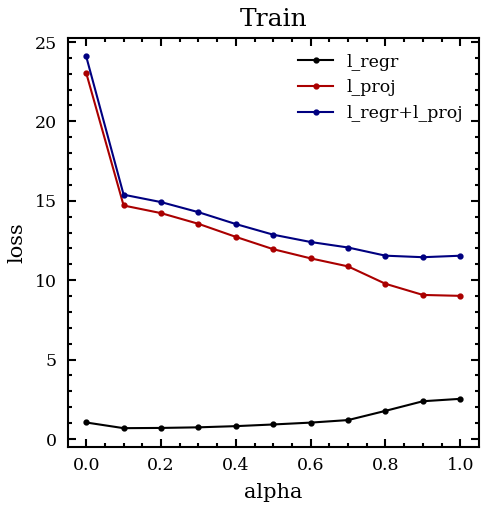

In [69]:
# Sum of projection and regression loss over all cantons for the train set
plt.plot(alphas, ltrs_train[:, opt_reg_idx], 'o-', label='l_regr')
plt.plot(alphas, ltks_train[:, opt_reg_idx], 'o-', label='l_proj')
plt.plot(alphas, ltrs_train[:, opt_reg_idx]+ltks_train[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
plt.legend()
plt.title('Train')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

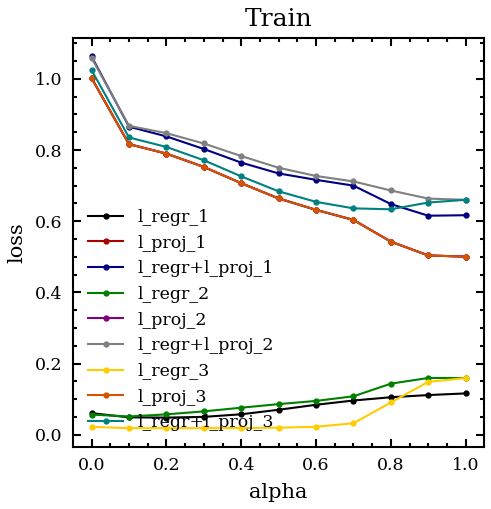

In [70]:
# Cantonwise losses for the train set
for i in range(0, 3):
    plt.plot(alphas, lrs_train[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
    plt.plot(alphas, lks_train[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
    plt.plot(alphas, lrs_train[:, opt_reg_idx, i]+lks_train[:, opt_reg_idx, i], 'o-', label=f'l_regr+l_proj_{i+1}')

plt.legend()
plt.title('Train')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

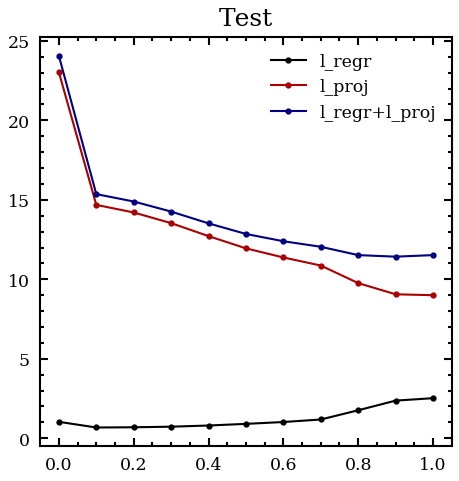

In [71]:
# Sum of projection and regression loss over all cantons for the test set
plt.plot(alphas, ltrs_test[:, opt_reg_idx], 'o-', label='l_regr')
plt.plot(alphas, ltks_test[:, opt_reg_idx], 'o-', label='l_proj')
plt.plot(alphas, ltrs_test[:, opt_reg_idx]+ltks_test[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
plt.legend()
plt.title('Test')
plt.show()

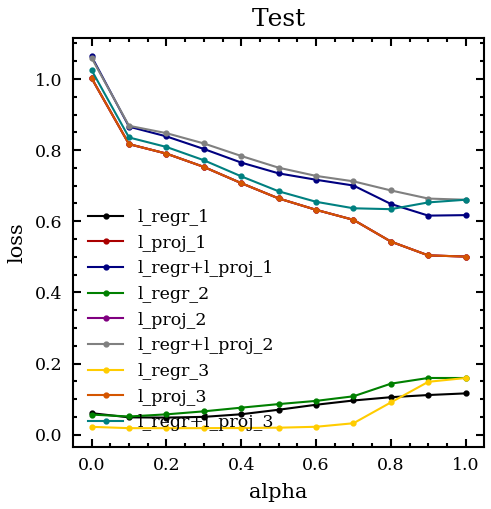

In [72]:
# Cantonwise losses for the train set
for i in range(0, 3):
    plt.plot(alphas, lrs_test[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
    plt.plot(alphas, lks_test[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
    plt.plot(alphas, lrs_test[:, opt_reg_idx, i]+lks_test[:, opt_reg_idx, i], 'o-', label=f'l_regr+l_proj_{i+1}')

plt.legend()
plt.title('Test')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

In [22]:
kpcovr = KPCovR2(alpha=opt_alpha, n_PC=n_kpcovr, regularization=opt_reg, rcond=None, center=True, scale=True)
kpcovr.fit(K_train_centered, Y_train)
T_train, Yp_train, _ = kpcovr.transform(K_train_centered)
T_test, Yp_test, _ = kpcovr.transform(K_test_centered)

In [23]:
# Similar to sklearn transformation, see multiclass._ovr_decision_function (BSD 3-Clause License)
df_type = 'ovo'
n_classes = 4
if df_type == 'ovo':
    vote_matrix_train = np.zeros((Y_train.shape[0], n_classes))
    vote_matrix_test = np.zeros((Y_test.shape[0], n_classes))
        
    # Predicted class determined by majority vote
    col_idx = 0
    for i in range(0, n_classes):
        for j in range(i + 1, n_classes):
            col_train = Y_train[:, col_idx]
            vote_matrix_train[col_train > 0, i] += 1
            vote_matrix_train[col_train <= 0, j] += 1
            
            col_test = Y_test[:, col_idx]
            vote_matrix_test[col_test > 0, i] += 1
            vote_matrix_test[col_test <= 0, j] += 1
            
            col_idx += 1
            
            # TODO: break ties with distances from hyperplane
            
    class_train = np.argmax(vote_matrix_train, axis=1) + 1
    class_test = np.argmax(vote_matrix_test, axis=1) + 1
            
else:
    
    # Predicted class determined by largest (positive) value of the decision function
    class_train = np.argmax(Yp_train, axis=1) + 1
    class_test = np.argmax(Yp_test, axis=1) + 1

In [64]:
# Simple classification accuracy
train_accuracy = np.count_nonzero(class_train == Y_svm_train) / len(Y_svm_train)
test_accuracy = np.count_nonzero(class_test == Y_svm_test) / len(Y_svm_test)

print(train_accuracy)
print(test_accuracy)
print(classification_report(Y_svm_train, class_train))
print(classification_report(Y_svm_test, class_test))
print(confusion_matrix(Y_svm_train, class_train))
print(confusion_matrix(Y_svm_test, class_test))

0.38440181726400807
0.37331594958713604
              precision    recall  f1-score   support

           1       0.01      1.00      0.02        22
           2       0.07      0.94      0.12        98
           3       0.02      0.56      0.04        54
           4       1.00      0.37      0.54      7750

    accuracy                           0.38      7924
   macro avg       0.27      0.72      0.18      7924
weighted avg       0.98      0.38      0.53      7924

              precision    recall  f1-score   support

           1       0.00      0.23      0.01        13
           2       0.04      0.71      0.08        24
           3       0.01      0.29      0.02        14
           4       1.00      0.37      0.54      2250

    accuracy                           0.37      2301
   macro avg       0.26      0.40      0.16      2301
weighted avg       0.98      0.37      0.53      2301

[[  22    0    0    0]
 [   5   92    1    0]
 [  20    4   30    0]
 [2272 1302 1274 2902

In [61]:
# Simple classification accuracy, DEEM only
train_accuracy = \
    np.count_nonzero(class_train[n_iza_train:] == Y_svm_train[n_iza_train:]) / len(Y_svm_train[n_iza_train:])
test_accuracy = \
    np.count_nonzero(class_test[n_iza_test:] == Y_svm_test[n_iza_test:]) / len(Y_svm_test[n_iza_test:])

print(train_accuracy)
print(test_accuracy)
print(classification_report(Y_svm_train[n_iza_train:], class_train[n_iza_train:], labels=[1, 2, 3, 4]))
print(classification_report(Y_svm_test[n_iza_test:], class_test[n_iza_test:], labels=[1, 2, 3, 4]))

0.3744516129032258
0.3711111111111111
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.37      0.54      7750

    accuracy                           0.37      7750
   macro avg       0.25      0.09      0.14      7750
weighted avg       1.00      0.37      0.54      7750

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.37      0.54      2250

    accuracy                           0.37      2250
   macro avg       0.25      0.09      0.14      2250
weighted avg       1.00      0.37      0.54      2250



In [62]:
# Simple classification accuracy, IZA only
train_accuracy = \
    np.count_nonzero(class_train[0:n_iza_train] == Y_svm_train[0:n_iza_train]) / len(Y_svm_train[0:n_iza_train])
test_accuracy = \
    np.count_nonzero(class_test[0:n_iza_test] == Y_svm_test[0:n_iza_test]) / len(Y_svm_test[0:n_iza_test])

print(train_accuracy)
print(test_accuracy)
print(classification_report(Y_svm_train[0:n_iza_train], class_train[0:n_iza_train]))
print(classification_report(Y_svm_test[0:n_iza_test], class_test[0:n_iza_test]))

0.8275862068965517
0.47058823529411764
              precision    recall  f1-score   support

           1       0.47      1.00      0.64        22
           2       0.96      0.94      0.95        98
           3       0.97      0.56      0.71        54

    accuracy                           0.83       174
   macro avg       0.80      0.83      0.76       174
weighted avg       0.90      0.83      0.83       174

              precision    recall  f1-score   support

           1       0.30      0.23      0.26        13
           2       0.50      0.71      0.59        24
           3       0.57      0.29      0.38        14

    accuracy                           0.47        51
   macro avg       0.46      0.41      0.41        51
weighted avg       0.47      0.47      0.45        51



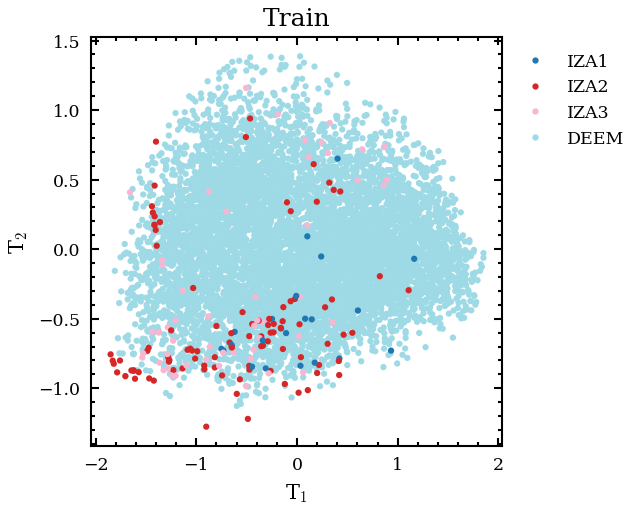

In [49]:
plt.scatter(T_train[n_iza_train:, 0], T_train[n_iza_train:, 1], 
            c=Y_svm_train[n_iza_train:], cmap='tab20', vmin=1, vmax=4, zorder=2)
plt.scatter(T_train[0:n_iza_train, 0], T_train[0:n_iza_train, 1], 
            c=Y_svm_train[0:n_iza_train], cmap='tab20', vmin=1, vmax=4, zorder=3)
#plt.scatter(T_train[:, 0], T_train[:, 1], c=Y_svm_train, cmap='tab20')
handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]
labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
plt.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.xlabel(r'T$_1$')
plt.ylabel(r'T$_2$')
plt.title('Train')

plt.savefig('../Results/6.0/svm-kpcovr-test_train.png', bbox_inches='tight')

plt.show()

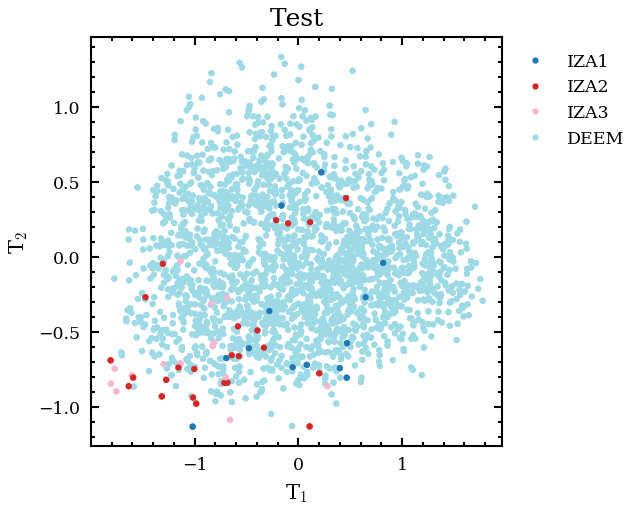

In [50]:
plt.scatter(T_test[n_iza_test:, 0], T_test[n_iza_test:, 1],
            c=Y_svm_test[n_iza_test:], cmap='tab20', vmin=1, vmax=4, zorder=2)
plt.scatter(T_test[0:n_iza_test, 0], T_test[0:n_iza_test, 1],
            c=Y_svm_test[0:n_iza_test], cmap='tab20', vmin=1, vmax=4, zorder=3)
plt.scatter(T_test[:, 0], T_test[:, 1], c=Y_svm_test, cmap='tab20')
handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]
labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
plt.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.xlabel(r'T$_1$')
plt.ylabel(r'T$_2$')
plt.title('Test')

plt.savefig('../Results/6.0/svm-kpcovr-test_test.png', bbox_inches='tight')

plt.show()